#INITIAL SETUP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
  # Fix randomness and hide warnings
  seed = 42

  import os
  os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
  os.environ['PYTHONHASHSEED'] = str(seed)
  os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

  import warnings
  warnings.simplefilter(action='ignore', category=FutureWarning)
  warnings.simplefilter(action='ignore', category=Warning)

  import numpy as np
  np.random.seed(seed)

  import logging

  import random
  random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import matplotlib.pyplot as plt
plt.rc('font', size=16)
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
import cv2
from keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
#GLOBAL VARIABLES
UPSAMPLING = False
BEST_TTA_ACCURACY=0

In [ ]:
%cd /content/drive/MyDrive/Challenge1/Challenge1_Luca

/content/drive/.shortcut-targets-by-id/1NoJFi6sZk7HK6-01JmQLA6FmpPbKh2jd/Challenge1/Challenge1_Luca


#DATA LOADING

In [ ]:
# Load the dataset
dataset = np.load('../extracted_data/public_data.npz', allow_pickle=True)

# Extract the arrays from the data
data = dataset['data']
labels = dataset['labels']

# Convert data and labels values into the correct data_type
data = np.array(data, dtype=np.uint8)

print(data.shape)
print(labels.shape)

(5200, 96, 96, 3)
(5200,)


# DATA SET PREPARATION



In [ ]:
def get_image_hash(image):
    #Converti l'immagine in una stringa
    image_string = image.tobytes()

    #Calcola la somma dei valori dei byte
    hash_value = sum(image_string)

    return hash_value

#Compute hash for each image
hashes = np.array([get_image_hash(image) for image in data])

#Find unique hashes and their indices
unique_hashes, indices = np.unique(hashes, return_index=True)

#Select the unique images and their corresponding labels
data_unique = data[indices]
labels_unique = labels[indices]

print(f"Original dataset size: {data.shape[0]}")
print(f"Unique dataset size: {data_unique.shape[0]}")

Original dataset size: 5200
Unique dataset size: 4849


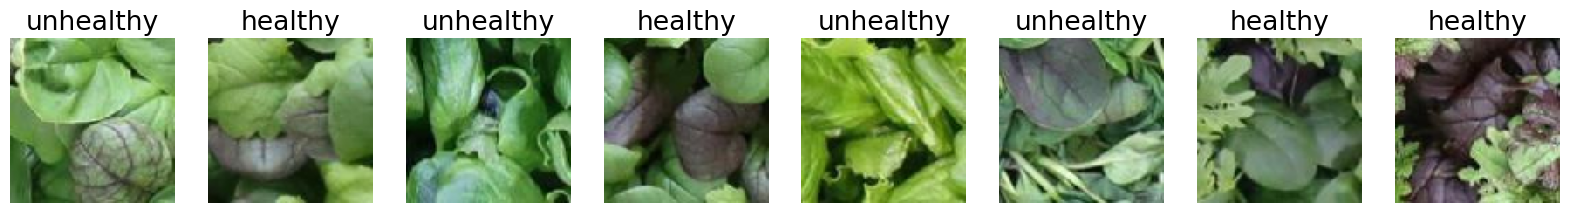

In [ ]:
# randomize the choice of images at each run
seed = random.randint(0, 1000)
random.seed(seed)
fig, ax = plt.subplots(1, 8, figsize=(20, 20))
for i in range(8):
    random_index = random.randint(0, data_unique.shape[0])
    ax[i].imshow(data_unique[random_index])
    ax[i].set_title(labels_unique[random_index])
    ax[i].axis('off')
plt.show()

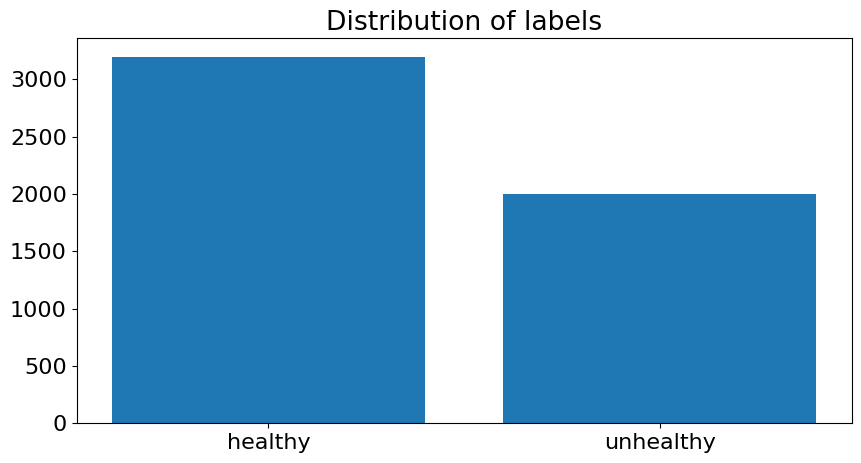

In [ ]:
from collections import Counter

counter_labels = Counter(labels)
labels_count, counts = zip(*counter_labels.items())

plt.figure(figsize=(10, 5))
plt.bar(labels_count, counts)
plt.title('Distribution of labels')
plt.show()

In [ ]:
#UPSAMPLING
#Find the indices of the healthy and unhealthy images
UPSAMPLING = True
healthy_indices = np.where(labels_unique == 'healthy')[0]
unhealthy_indices = np.where(labels_unique == 'unhealthy')[0]

#Determine the number of images to sample from the unhealthy class to match the healthy class
num_samples = len(healthy_indices)

#Upsample the unhealthy class
if len(unhealthy_indices) < num_samples:
    unhealthy_upsampled_indices = np.random.choice(unhealthy_indices, size=num_samples, replace=True)
    new_indices = np.concatenate([healthy_indices, unhealthy_upsampled_indices])
else:
    new_indices = np.concatenate([healthy_indices, unhealthy_indices])

#Use the new indices to create a balanced dataset
data_balanced = data_unique[new_indices]
labels_balanced = labels_unique[new_indices]

#Function to count class instances
def count_classes(labels_to_count):
    unique, item_counts = np.unique(labels_to_count, return_counts=True)
    class_counts = dict(zip(unique, item_counts))
    return class_counts

# Count classes before upsampling
original_class_counts = count_classes(labels_unique)
print("Original class counts:", original_class_counts)

# Count classes after upsampling
upsampled_class_counts = count_classes(labels_balanced)
print("Upsampled class counts:", upsampled_class_counts)

# Check if the classes are balanced after upsampling
if len(set(upsampled_class_counts.values())) == 1:
    print("The classes are balanced.")
else:
    print("The classes are not balanced.")

# Use the indices of the upsampled 'unhealthy' class to get the images to be augmented
upsampled_unhealthy_images = data_unique[unhealthy_upsampled_indices]

Original class counts: {'healthy': 3060, 'unhealthy': 1789}
Upsampled class counts: {'healthy': 3060, 'unhealthy': 3060}
The classes are balanced.


In [ ]:
# Convert labels to one-hot encoding
label_mapping = {'healthy': 0, 'unhealthy': 1}
if not UPSAMPLING:
  numeric_labels = [label_mapping[label] for label in labels_unique]
else:
  numeric_labels = [label_mapping[label] for label in labels_balanced]

one_hot_labels = np.array(numeric_labels)

#DATA SET SPLITTING

In [ ]:
# Split the data into training and validation sets
# 85% of the data goes into the training set and 15% into the validation set
if UPSAMPLING:
  train_data, val_data, train_labels, val_labels = train_test_split(
      data_balanced, one_hot_labels, test_size=0.15, random_state=seed, stratify=one_hot_labels)
else:
  train_data, val_data, train_labels, val_labels = train_test_split(
      data_unique, one_hot_labels, test_size=0.15, random_state=seed, stratify=one_hot_labels)

# Print the shape of the training and validation sets
print(train_data.shape, train_labels.shape)
print(val_data.shape, val_labels.shape)

(4121, 96, 96, 3) (4121,)
(728, 96, 96, 3) (728,)


#EFFICIENT_NETB0 MODEL

##TRANSFER LEARNING

###model definition

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

#efficientNetB0 imported from keras as base model
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None
)

#set the efficientNet to non trainable for transfer learning
base_model.trainable = False

#pre processing layers
preprocessing = tf.keras.Sequential([
    tf.keras.layers.Lambda(preprocess_input, input_shape=(96, 96, 3)),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
], name='preprocessing')

inputs = tfk.Input(shape=(96,96,3))

preprocessing = preprocessing(inputs)
x = tf.keras.layers.Resizing( 224, 224, interpolation='bilinear', crop_to_aspect_ratio=True,) (preprocessing)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tfkl.Dropout(0.5, seed=seed)(x)
x = tfkl.Dense(
    1024,
    activation='leaky_relu',)(x)

output_layer = tfkl.Dense(units=1, activation='sigmoid', name='Output')(x)

# Connect input and output through the Model class
model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')


learning_rate = 5e-4

# compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

definitons of the callbacks to pass to the model

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 6, factor= 0.5, min_lr= 5e-5, verbose=1)

callbacks = []

callbacks.append(rlrop)
callbacks.append(early_stopping)

###k fold cross validation

we use k fold cross validation to see if the values of accuracy and loss are consistent over each fold. We also keep track of the best epoch in order to use it later to train the model on the entire data-set.

In [ ]:
# Define the number of splits for KFold
n_splits = 4
foldCount= 1
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
all_history = []
best_epochs = []

# Loop over each fold
for train_index, val_index in kf.split(data_unique):
    train_data, val_data = data_balanced[train_index], data_balanced[val_index]
    train_labels, val_labels = one_hot_labels[train_index], one_hot_labels[val_index]

    # Create a new instance of the model (this is important to reset weights)
    model = tf.keras.Model(inputs=inputs, outputs=output_layer, name='model') #note this has to be within the for loop since it re initialized the weights
    learning_rate = 5e-4  # This sets the learning rate to 0.00001
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    ) # dflt learning rate 1e-3


    # Train the model
    history = model.fit(
        x=train_data,
        y=train_labels,
        epochs=200,
        validation_data=(val_data, val_labels),
        #class_weight=class_weight_dict, #to be removed in case of upsampling/downsampling
        callbacks=callbacks,
    ).history

    all_history.append(history)

    # Store the best epoch for the current fold
    # if early stopping didn't occur, use the last epoch as the best epoch
    patience = 10
    best_epoch = early_stopping.stopped_epoch - (patience - 1) if early_stopping.stopped_epoch > 0 else 199
    best_epochs.append(best_epoch)
    average_best_epoch = sum(best_epochs)/len(best_epochs)
    print(f"best epoch: {best_epochs[-1]}")
    foldCount += 1

Epoch 1/200
114/114 [==============================] - 27s 113ms/step - loss: 0.4722 - accuracy: 0.7794 - precision_3: 0.7259 - recall_3: 0.6363 - val_loss: 0.3920 - val_accuracy: 0.8285 - val_precision_3: 0.9016 - val_recall_3: 0.6161 - lr: 5.0000e-04
Epoch 2/200
114/114 [==============================] - 10s 88ms/step - loss: 0.4572 - accuracy: 0.7860 - precision_3: 0.7417 - recall_3: 0.6355 - val_loss: 0.3929 - val_accuracy: 0.8211 - val_precision_3: 0.8987 - val_recall_3: 0.5965 - lr: 5.0000e-04
Epoch 3/200
114/114 [==============================] - 10s 91ms/step - loss: 0.4606 - accuracy: 0.7827 - precision_3: 0.7319 - recall_3: 0.6393 - val_loss: 0.3732 - val_accuracy: 0.8508 - val_precision_3: 0.8553 - val_recall_3: 0.7310 - lr: 5.0000e-04
Epoch 4/200
114/114 [==============================] - 10s 92ms/step - loss: 0.4482 - accuracy: 0.7885 - precision_3: 0.7407 - recall_3: 0.6476 - val_loss: 0.3730 - val_accuracy: 0.8409 - val_precision_3: 0.7978 - val_recall_3: 0.7787 - lr: 5.

In [ ]:
# Use the best average epoch from your cross-validation
average_best_epoch = sum(best_epochs)/len(best_epochs)
final_epochs = int(average_best_epoch)

# Create a new model instance (resetting weights)
model = tf.keras.Model(inputs=inputs, outputs=output_layer, name='final_model') #this has to be run to be able to run fine tunng afterwards

learning_rate = 2e-4  # This sets the learning rate to 0.00001
model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

# Train the model on the entire dataset
model.fit(
    x=data_balanced,  # Your entire dataset
    y=one_hot_labels,
    epochs=final_epochs,
    #class_weight=class_weight_dict,
    batch_size = 32, #64
    validation_data = (val_data, val_labels),
    callbacks = callbacks,
)


#model.save('WeightedKfoldModelSlowLR')
#del model

### normal training without kfold cross-validation and on upsampled test set

In [ ]:
# Train the model
history = model.fit(
    x = train_data,
    y= train_labels,
    epochs = 200,
    batch_size = 32, #64
    validation_data = (val_data, val_labels),
    callbacks = callbacks,
).history

Epoch 1/200
129/129 [==============================] - 20s 100ms/step - loss: 0.5562 - accuracy: 0.7171 - val_loss: 0.4290 - val_accuracy: 0.8104 - lr: 5.0000e-04
Epoch 2/200
129/129 [==============================] - 11s 89ms/step - loss: 0.5131 - accuracy: 0.7496 - val_loss: 0.4269 - val_accuracy: 0.8118 - lr: 5.0000e-04
Epoch 3/200
129/129 [==============================] - 10s 80ms/step - loss: 0.5114 - accuracy: 0.7503 - val_loss: 0.4268 - val_accuracy: 0.8077 - lr: 5.0000e-04
Epoch 4/200
129/129 [==============================] - 11s 87ms/step - loss: 0.4728 - accuracy: 0.7765 - val_loss: 0.4014 - val_accuracy: 0.8187 - lr: 5.0000e-04
Epoch 5/200
129/129 [==============================] - 10s 79ms/step - loss: 0.4761 - accuracy: 0.7709 - val_loss: 0.4053 - val_accuracy: 0.8269 - lr: 5.0000e-04
Epoch 6/200
129/129 [==============================] - 10s 78ms/step - loss: 0.4741 - accuracy: 0.7743 - val_loss: 0.4309 - val_accuracy: 0.8091 - lr: 5.0000e-04
Epoch 7/200
129/129 [======

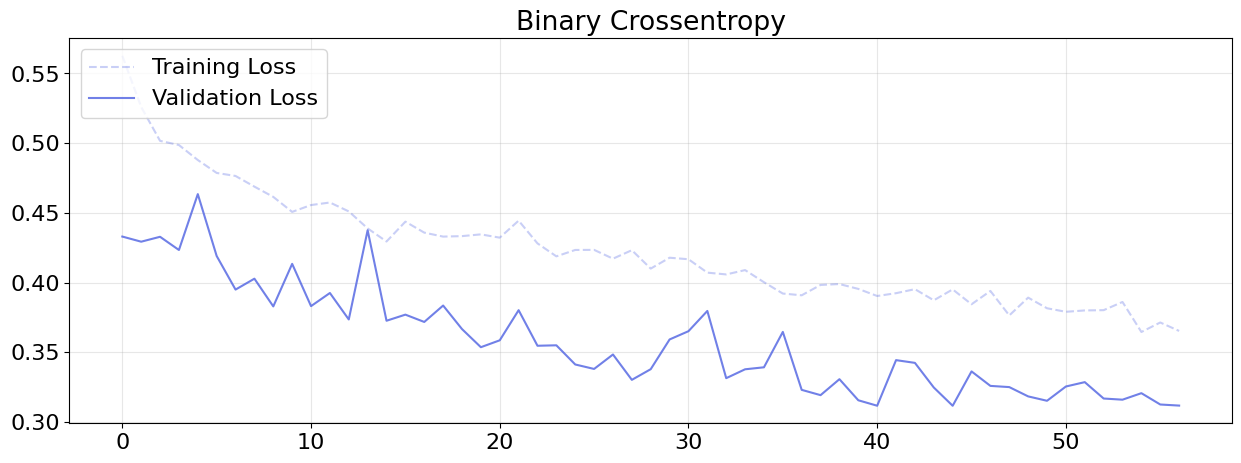

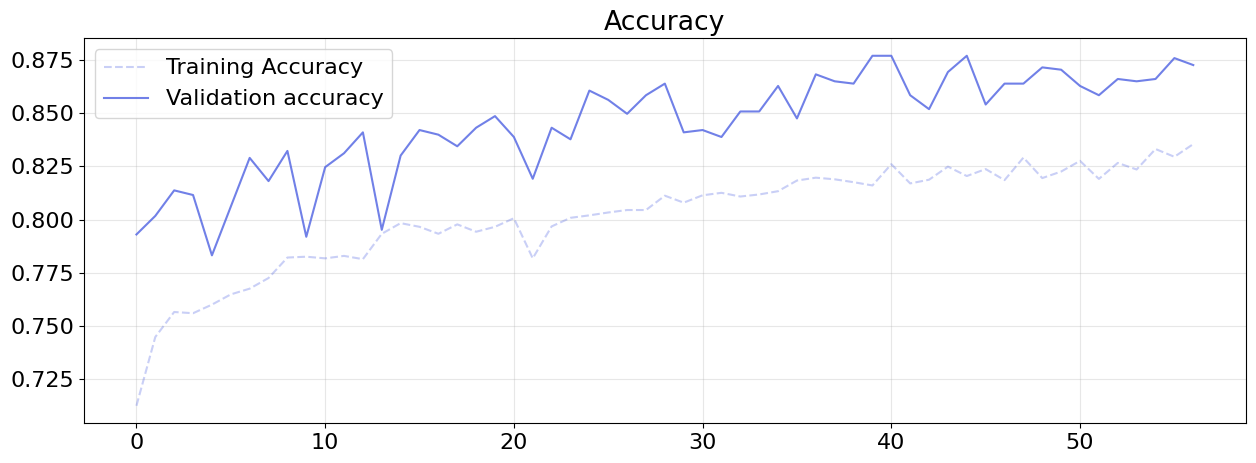

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
%ls

 baseLineModel/                               EfficientNetXXX1SmallBatchFT/
 BaseLine_simpleCNN.ipynb                     EfficientNetXXX1SmallBatchFT2/
'Copia di Copia di ResNet152V2_96.ipynb'      EfficientNetXXX1SmallBatchTL/
 duplicates/                                  EffiecientNet_weighted.ipynb
 efficientNet087Base.ipynb                    ensemble.ipynb
 EfficientNet_087.ipynb                       firstModelLuca.ipynb
 EfficientNet_088.ipynb                       last_hope/
 EfficientNet_088Mixup.ipynb                  last_hope2/
 EfficientNet_088_reducedAugmentation.ipynb   model.png
 EfficientNet_B3.ipynb                        progressiveFTModel/
 efficientNetTTA.0874/                        ResNet152V2_96.ipynb
 EfficientNet_withProgressiveFT.ipynb         Resnet152v2fine_tuned/
 EFFICIENTNETXX1TTA/                          ResnetV1TL/
 EFFICIENTNETXX1TTAft/                       'Transfer Learning and Fine Tuning.ipynb'
 EfficientNetXXX1/                            Weig

In [ ]:
model.save('efficientNetNoUpsamplingFinal')
del model

In [ ]:
max_accuracy = max(history['accuracy'])
max_val_accuracy = max(history['val_accuracy'])

print(f"Maximum training accuracy: {max_accuracy}")
print(f"Maximum validation accuracy: {max_val_accuracy}")

## FINE TUNING

In [ ]:
# Re-load the model after transfer learning
#model = tfk.models.load_model('efficientNetXXX1_fine_tuning1')
model = tfk.models.load_model('efficientNetNoUpsamplingFinal')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0     

In [ ]:
# Set all layers to Trainable
model.get_layer('efficientnetb0').trainable = True

In [ ]:
#FINETUNING BLOCKs 6, 7
for i, layer in enumerate(model.get_layer('efficientnetb0').layers[:163]):
  layer.trainable=False
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0     

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=11, restore_best_weights=True)

rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 6, factor= 0.5, min_lr= 2e-6, verbose=1)

callbacks2 = []

callbacks2.append(rlrop)
callbacks2.append(early_stopping)

In [ ]:
# Ricompila il modello con un learning rate più basso per il fine-tuning
model.compile(
    loss=tfk.losses.BinaryCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=2e-5),  # un learning rate più basso per il fine-tuning
    metrics=['accuracy']
)

In [ ]:
# Continua l'allenamento con fine-tuning
history_fine_tune = model.fit(
    x = train_data,
    y = train_labels,
    epochs = 150,
    batch_size = 32,
    validation_data = (val_data, val_labels),
    callbacks = callbacks2,
).history

Epoch 1/150
129/129 [==============================] - 36s 132ms/step - loss: 0.4017 - accuracy: 0.8187 - val_loss: 0.3500 - val_accuracy: 0.8544 - lr: 2.0000e-05
Epoch 2/150
129/129 [==============================] - 15s 118ms/step - loss: 0.3787 - accuracy: 0.8335 - val_loss: 0.3695 - val_accuracy: 0.8503 - lr: 2.0000e-05
Epoch 3/150
129/129 [==============================] - 14s 110ms/step - loss: 0.3615 - accuracy: 0.8347 - val_loss: 0.3185 - val_accuracy: 0.8571 - lr: 2.0000e-05
Epoch 4/150
129/129 [==============================] - 15s 118ms/step - loss: 0.3585 - accuracy: 0.8389 - val_loss: 0.3130 - val_accuracy: 0.8695 - lr: 2.0000e-05
Epoch 5/150
129/129 [==============================] - 15s 117ms/step - loss: 0.3421 - accuracy: 0.8476 - val_loss: 0.3088 - val_accuracy: 0.8654 - lr: 2.0000e-05
Epoch 6/150
129/129 [==============================] - 15s 117ms/step - loss: 0.3348 - accuracy: 0.8559 - val_loss: 0.3029 - val_accuracy: 0.8681 - lr: 2.0000e-05
Epoch 7/150
129/129 [=

In [ ]:
max_accuracy = max(history_fine_tune['accuracy'])
max_val_accuracy = max(history_fine_tune['val_accuracy'])

print(f"Maximum training accuracy: {max_accuracy}")
print(f"Maximum validation accuracy: {max_val_accuracy}")

Maximum training accuracy: 0.9325406551361084
Maximum validation accuracy: 0.901098906993866


In [ ]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
model.save('efficientNetNoUpsamplingFinal_fineTuned')

In [ ]:
%ls

 baseLineModel/                               EfficientNetXXX1_fine_tuning1/
 BaseLine_simpleCNN.ipynb                     EfficientNetXXX1SmallBatchFT/
'Copia di Copia di ResNet152V2_96.ipynb'      EfficientNetXXX1SmallBatchFT2/
 duplicates/                                  EfficientNetXXX1SmallBatchTL/
 efficientNet087Base.ipynb                    EffiecientNet_weighted.ipynb
 EfficientNet_087.ipynb                       ensemble.ipynb
 EfficientNet_088.ipynb                       firstModelLuca.ipynb
 EfficientNet_088Mixup.ipynb                  last_hope/
 EfficientNet_088_reducedAugmentation.ipynb   last_hope2/
 EfficientNet_B3.ipynb                        model.png
 efficientNetNoUpsamplingFinal/               progressiveFTModel/
 efficientNetNoUpsamplingFinal_fineTuned/     ResNet152V2_96.ipynb
 efficientNetTTA.0874/                        Resnet152v2fine_tuned/
 EfficientNet_withProgressiveFT.ipynb         ResnetV1TL/
 EFFICIENTNETXX1TTA/                         'Transfer Learn

# TEST TIME AUGMENTATION

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#define transformation to be applied during TTA
test_datagen = ImageDataGenerator(
    rotation_range=20,      # Rotate the image slightly (e.g., 20 degrees)
    width_shift_range=0.1,  # Shift the image horizontally
    height_shift_range=0.1, # Shift the image vertically
    horizontal_flip=True,   # Flip the image horizontally
    vertical_flip=True,     # Flip the image vertically
    #brightness_range=[0.8, 1.2]  # Adjust brightness (assuming this is the correct usage)
)

In [ ]:
model2 = tfk.models.load_model('EfficientNetXXX1_fine_tuning1')

In [ ]:
model = tfk.models.load_model('model2')

In [ ]:
#this takes the highest probability prediction
def predict_with_tta_hprob(model, datagen, images, labels, num_augmentations=7):
    # Initialize an array to store the highest probability for each image
    highest_prob_predictions = np.zeros(len(images))

    for _ in range(num_augmentations):
        aug_iter = datagen.flow(images, labels, batch_size=len(images), shuffle=False)
        aug_images, _ = next(aug_iter)
        current_predictions = model.predict(aug_images).squeeze()

        # Update highest probability predictions
        highest_prob_predictions = np.maximum(highest_prob_predictions, current_predictions)

    return highest_prob_predictions

In [ ]:
#this takes the avg of the predictions
def predict_with_tta_avg(model, datagen, images, labels, num_augmentations=7):
    predictions = np.zeros(len(images))  # Assuming binary classification

    for _ in range(num_augmentations):
        aug_iter = datagen.flow(images, labels, batch_size=len(images), shuffle=False)
        aug_images, _ = next(aug_iter)
        predictions += model.predict(aug_images).squeeze()
    predictions /= num_augmentations
    return predictions


In [ ]:
from sklearn.metrics import accuracy_score

#make predictions with the two different variants to check which is better
tta_predictions1 = predict_with_tta_avg(model, test_datagen, val_data, val_labels)
tta_predictions2 = predict_with_tta_hprob(model, test_datagen, val_data, val_labels)

# Convert probabilities to class labels
tta_predictions_avg = (tta_predictions1 > 0.5).astype(int)
tta_predictions_hp = (tta_predictions2 > 0.5).astype(int)

# Evaluate performance
tta_accuracy_1 = accuracy_score(val_labels, tta_predictions_avg)
print(f"model1 tta accuract avg {tta_accuracy_1}")
tta_accuracy_2 = accuracy_score(val_labels, tta_predictions_hp)
print(f"model1 tta accuract hp {tta_accuracy_2}")

29/29 [==============================] - 2s 59ms/step
model1 tta accuract avg 0.9422657952069716
model1 tta accuract hp 0.9455337690631809


In [ ]:
print("Accuracy with TTA:", tta_accuracy)
BEST_TTA_ACCURACY= max(BEST_TTA_ACCURACY, tta_accuracy)
BEST_TTA_ACCURACY

Accuracy with TTA: 0.9628712871287128


0.9628712871287128

In [ ]:
model.save('last_hope')
del model